In [1]:
!pip install pytorch_lightning
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 kB 4.4 MB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 6.3 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.5 MB/s eta 0:00:0031m23.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 16.5 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 9.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 14.7 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.8 MB/s eta 0:00:00m eta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.1/262.1 kB 6.3 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 7.6 MB/s eta 0:00:00 MB/s eta 0:00:01
  Created wheel for lit: filename=lit-16.0.0-py3-none-any.whl size=93582 sha256=9b1dfb8a7ec10819f2bbef5b73dae46d337aca9883e3c0467da9136e4ac029d9
  Stored in directory: /home/cats/.cache/pip/wheels/30/c8/c0/9d24f63f30f4879b8efb718a11b2191ef5c8510259d1d6c392
Successfully built lit
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Using cached tensorboardX-2.6-py2.py3-none-any.whl (114 kB)
  Using cached protobuf-3.20.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)


In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

2023-04-02 17:55:29.964839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 17:55:30.479718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Create pairs (first track, subsequent track, time)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [5]:
DATA_DIR = "/home/cats/Downloads/log/"

In [6]:
data = pd.read_json(DATA_DIR + "data.json", lines=True)

In [7]:
len(data)

79785

In [5]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs

In [28]:
tracks = pd.read_json("/home/cats/Files/Homework/RecSys/recsys-itmo-spring-2023/botify/data/tracks_with_recs.json", lines=True)

In [29]:
tracks.head()

,artist,title,track,recommendations
0,Jack Johnson,The Cove,0,"[5238, 4143, 1987, 10716, 6717, 419, 4184, 557..."
1,Billy Preston,Nothing from Nothing,1,"[1142, 1305, 444, 442, 1275, 129, 140, 1520, 1..."
2,Paco De Lucia,Entre Dos Aguas,2,"[8483, 3101, 21811, 3413, 1501, 3611, 20675, 6..."
3,Josh Rouse,Under Cold Blue Stars,3,"[2584, 24444, 311, 4446, 7938, 3146, 588, 595,..."
4,The Dead 60s,Riot Radio (Soundtrack Version),4,"[35485, 19254, 14969, 14961, 3424, 3759, 1390,..."


In [40]:
sorted(tracks[tracks['track'] == 1159]['recommendations'].values[0])

[299,
 300,
 302,
 306,
 309,
 313,
 338,
 346,
 347,
 349,
 352,
 360,
 388,
 394,
 517,
 543,
 563,
 577,
 729,
 735,
 740,
 796,
 830,
 865,
 911,
 920,
 974,
 993,
 1069,
 1105,
 1115,
 1159,
 1161,
 1175,
 1177,
 1743,
 1748,
 1829,
 2008,
 2010,
 2011,
 2100,
 2104,
 2119,
 2125,
 2128,
 2225,
 2308,
 2313,
 2356,
 2404,
 2417,
 2490,
 2493,
 2957,
 3193,
 3406,
 3553,
 3649,
 3733,
 3887,
 3901,
 4360,
 4364,
 4432,
 4869,
 4913,
 5734,
 6808,
 6817,
 6905,
 6910,
 7500,
 7514,
 7542,
 7547,
 7735,
 9274,
 9707,
 9803,
 9838,
 9850,
 10195,
 10197,
 10200,
 10852,
 12813,
 12913,
 12933,
 14545,
 16831,
 17482,
 17649,
 17696,
 20447,
 22852,
 25783,
 34494,
 40651,
 47631]

In [32]:
data[data['user'] == 2]

,message,timestamp,user,track,time,latency,recommendation,experiments
47600,next,2023-04-02 15:00:40.314,2,470,1.00,0.000366,504.0,{'CONTEXTUAL': 'T1'}
47604,next,2023-04-02 15:00:40.321,2,504,1.00,0.000383,691.0,{'CONTEXTUAL': 'T1'}
47607,next,2023-04-02 15:00:40.328,2,691,1.00,0.000572,1159.0,{'CONTEXTUAL': 'T1'}
47610,next,2023-04-02 15:00:40.337,2,1159,0.80,0.001208,4869.0,{'CONTEXTUAL': 'T1'}
47612,next,2023-04-02 15:00:40.349,2,4869,0.11,0.000452,12380.0,{'CONTEXTUAL': 'T1'}
47614,next,2023-04-02 15:00:40.359,2,12380,0.14,0.000319,68.0,{'CONTEXTUAL': 'T1'}
47616,next,2023-04-02 15:00:40.365,2,68,1.00,0.000481,4869.0,{'CONTEXTUAL': 'T1'}
47619,next,2023-04-02 15:00:40.372,2,4869,0.00,0.000301,14346.0,{'CONTEXTUAL': 'T1'}
47622,next,2023-04-02 15:00:40.382,2,14346,0.20,0.000374,2287.0,{'CONTEXTUAL': 'T1'}
47625,last,2023-04-02 15:00:40.389,2,2287,0.20,0.000134,NaN,{'CONTEXTUAL': 'T1'}


In [6]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

In [10]:
pairs.head()

,user,start,track,time
0,0,2999,5089,0.0
1,0,2999,5992,0.0
2,0,2999,7960,0.0
3,0,2999,1725,0.0
4,0,2999,2606,0.0


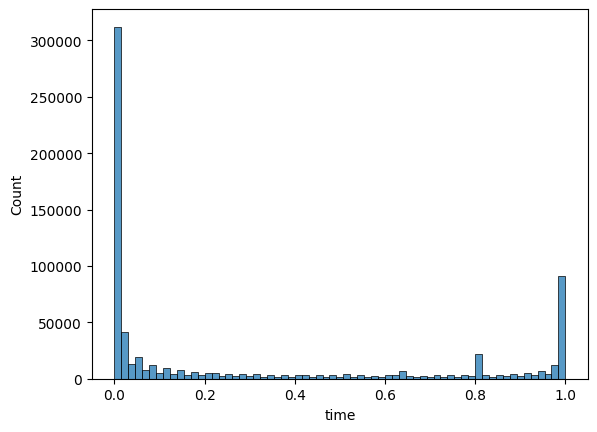

In [7]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

In [12]:
def get_firsts(user_data):
    times = []
    first = True
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first:
            times.append(row["time"])
            first = False
        
        if row["message"] == "last":
            first = True
            
    return times

In [16]:
data.groupby("user").apply(get_firsts).explode().values

array([1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0], dtype=object)

In [17]:
firsts = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_firsts)
    .explode()
    .values
    .tolist(),
    columns=["time"]
)

firsts.head()

,time
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [19]:
firsts.mean()

time    0.998557
dtype: float64

<Axes: xlabel='time', ylabel='Count'>

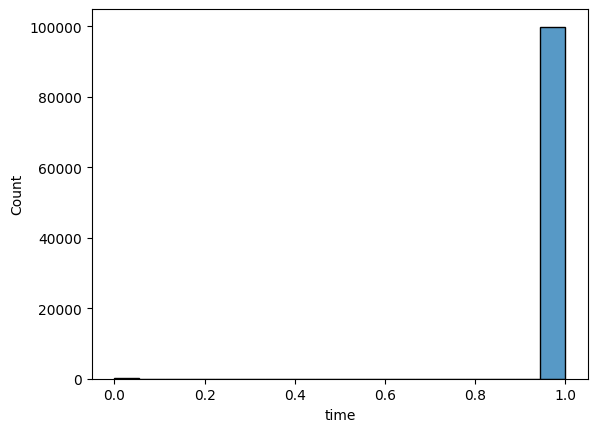

In [21]:
figure, ax = plt.subplots()
sns.histplot(firsts["time"], ax=ax)

## Train Model

In [8]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(572587, 70915, 71742)

In [ ]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)

    def forward(self, x):
        context = self.context(x[:, 0]) # start track
        track = self.track(x[:, 1]) # next track
        return torch.sum(context * track, dim=1)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [ ]:
class ContextualRankerData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, features):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features

    def prepare_data(self):
        self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
        self.train_dataset = td.TensorDataset(
            torch.from_numpy(self.train_data[self.features].values), 
            torch.from_numpy(self.train_data["time"].values)
            )

        self.val_dataset = td.TensorDataset(
            torch.from_numpy(self.val_data[self.features].values), 
            torch.from_numpy(self.val_data["time"].values)
            )

        if stage == "test" or stage is None:  
        self.test_dataset = td.TensorDataset(
            torch.from_numpy(self.test_data[self.features].values),
            torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
        )

    def train_dataloader(self):
        return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

    def test_dataloader(self):
        return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [ ]:
net = ContextualRanker(embedding_dim=100)
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='gpu', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs --host localhost

In [ ]:
trainer.fit(
    net, 
    data_module
)

In [ ]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path, embedding_dim=100)

In [ ]:
trainer.test(best, data_module)

## Compute top recommendations

In [ ]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)

In [ ]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [ ]:
track_meta.head()

In [ ]:
k = 100
with open(DATA_DIR + "tracks_with_recs.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
        
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        
        rf.write(json.dumps(recommendation) + "\n")

In [ ]:
track = 3916
embedding = context_embeddings[track]
track_meta.loc[track_meta["track"] == track, ["artist", "title"]]

In [ ]:
k = 10
neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
track_meta.loc[track_meta["track"].isin(neighbours), ["artist", "title"]]